In [ ]:
!git clone https://github.com/XL2248/MSCTD.git

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 14.54 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read main data from drive

!unzip -q "/content/drive/MyDrive/DeepLearning_Project/train_ende.zip"
!unzip -q "/content/drive/MyDrive/DeepLearning_Project/test.zip"
!unzip -q "/content/drive/MyDrive/DeepLearning_Project/dev.zip"

In [ ]:
# Import libraries

import os
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToTensor, Lambda, transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, TensorDataset, DataLoader, ConcatDataset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import cv2 as cv
import numpy as np
import cv2
import dlib
import time
from __future__ import print_function, division
import copy
import pathlib

from torchsummary import summary

import random
import glob
import re
import itertools


from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import *
from sklearn.utils import shuffle





device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [ ]:
y_h = lambda y : torch.zeros(3, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)
class MSCTDDataset(Dataset):
    
    def __init__(self, path_to_dataset = None, transform=None, target_transform=None):
        if path_to_dataset == 'path_to_dataset_train':
            Data = 'train'
            path_english_text = 'english_train'
            path_sentiment_text = 'sentiment_train'
            path_image = 'train_ende'
        elif path_to_dataset == 'path_to_dataset_test':
            Data = 'test'
            path_download = 'test_ende'
            path_english_text = 'english_test'
            path_sentiment_text = 'sentiment_test'
            path_image = 'test'
        elif path_to_dataset == 'path_to_dataset_dev':
            Data = 'dev'
            path_download = 'dev'
            path_english_text = 'english_dev'
            path_sentiment_text = 'sentiment_dev'
            path_image = 'dev'
        else:
            return TypeError, path_to_dataset + " is invalid"
        #!unzip "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/deepproject/train_ende.zip"
        english_text_path = f"/content/MSCTD/MSCTD_data/ende/{path_english_text}.txt"
        sentiment_path = f"/content/MSCTD/MSCTD_data/ende/{path_sentiment_text}.txt"
        self.image_path = f"/content/{path_image}/"

        with open(english_text_path) as f:
          english_text = [line.strip() for line in f.readlines()]
        print(f"{Data} english_text", len(english_text))
        self.englishtext = english_text

        with open(sentiment_path) as f:
          sentiment = [line.strip() for line in f.readlines()]
        self.sentiment = sentiment
        print(f"{Data} sentiment", len(sentiment))
        
        Images = os.listdir(self.image_path)
        Images.sort(key = lambda x:  int(x.split(".")[0]))
        self.Images = Images
        # self.target = target
        # self.features = features
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.sentiment)

    def __getitem__(self, idx):

        img_path = os.path.join(self.image_path, self.Images[idx])

        img = cv.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # Chnage channel due to imread function read images in BGR coding.
        sntmnt = self.sentiment[idx]
        englsh_txt = self.englishtext[idx]

        if self.target_transform:
            label = y_h(sntmnt)
        if self.transform:
            img = cv2.resize(img,(64,64))
            img = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])(img)
            sntmnt = int(sntmnt)
        return img, englsh_txt, sntmnt 

In [ ]:
main_train = MSCTDDataset('path_to_dataset_train', target_transform = False)
main_test = MSCTDDataset('path_to_dataset_test', target_transform = False)
main_dev = MSCTDDataset('path_to_dataset_dev', target_transform = False)

train english_text 20240
train sentiment 20240
test english_text 5067
test sentiment 5067
dev english_text 5063
dev sentiment 5063


In [ ]:
# One input of test
image, en_text, sentiment = main_test[2]
print("text sequence:", en_text)
print("label of sequence:", sentiment)

text sequence: I'm not happy about it either, okay? At all.
label of sequence: 1


# Part1_1

In [ ]:
!pip -q install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 79.0 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, BertModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


## Load face_model

In [ ]:
# Face model
import torch.nn.functional as F
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3,padding='same')
        self.max_pool1 = nn.MaxPool2d(kernel_size = 4, stride = 4)
        
        self.conv_layer3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3,padding='same')
        self.max_pool2 = nn.MaxPool2d(kernel_size = 4, stride = 4)

        self.conv_layer5 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3,padding='same')
        self.max_pool3 = nn.MaxPool2d(kernel_size = 4, stride = 4)

        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(8, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)
        out = self.conv_layer3(out)
        out = self.relu1(out)
        out = self.max_pool2(out)
        out = self.conv_layer5(out)
        out = self.max_pool3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

In [ ]:

class BERT_Arch(nn.Module):
   def __init__(self, bert, intents):      
       super(BERT_Arch, self).__init__()
       self.bert = bert 
       self.intents = intents
       self.fc1 = nn.Linear(768,256)      
       self.fc2 = nn.Linear(256,64)
       self.fc3 = nn.Linear(64,16)
       self.fc4 = nn.Linear(16,self.intents)
       self.relu = nn.ReLU()
       self.softmax = nn.LogSoftmax(dim=1)
   def forward(self, sent_id, mask):
      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.fc2(x)
      x = self.relu(x)
      x = self.fc3(x)
      x = self.relu(x)
      x = self.fc4(x)
      x = self.softmax(x)
      return x

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(EnsembleModel, self).__init__()
        self.fc1 = nn.Linear(hidden_size, 8)
        self.fc2 = nn.Linear(8,3)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        out = self.softmax(x)
        return out

In [ ]:
Face_model = torch.load('/content/drive/MyDrive/DL_Phase2_models/face.pt',map_location=device)
Bert_model = torch.load('/content/drive/MyDrive/DL_Phase2_models/BertModel.pt',map_location=device)


hidden_size = Bert_model.fc3.out_features + Face_model.fc2.in_features

Multi_model = EnsembleModel(hidden_size, num_classes = 3)

## DataLoader

In [ ]:
# This dataset will be used to load text and image in arbitary format for image and text model

class TextFaceDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, Face_model, Bert_model):
      self.dataset = dataset
      self.bert = Bert_model
      self.face = Face_model
      self.transform = transforms.Compose([transforms.ToTensor()])
  def __len__(self):
      return len(self.dataset)
  def __getitem__(self, idx):
      activation = {}
      def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
      loaded_image, text, label = self.dataset[idx]
      image = cv2.resize(loaded_image, (64,64))
      image = self.transform(image)
      image = image.expand(1,3,64,64)
      text = re.sub("[^-9A-Za-z ]", "" , text)
      token = tokenizer(text, max_length = 10, padding = 'max_length', truncation = True)
      seq = torch.tensor(token['input_ids'])
      mask = torch.tensor(token['attention_mask'])
      label = torch.tensor(int(label))
      image, mask, seq, label = image.to(device), mask.to(device), seq.to(device), label.to(device)
      self.face.max_pool3.register_forward_hook(get_activation('max_pool3'))
      out1 = self.face(image)
      face_fc = activation['max_pool3']
      self.bert.fc3.register_forward_hook(get_activation('fc3'))
      seq = seq.expand(1,10)
      mask = mask.expand(1,10)
      out2 = self.bert(seq, mask)
      bert_fc = activation['fc3']
      face_fc = face_fc.reshape(1,8)
      X = torch.cat((face_fc, bert_fc), 1)
      return X, label


In [ ]:
# This function is used to apply 2 models on data and concatenate the fc layer befor softmax layer
def ProvideData(dataset, Bert_model, Face_model):
      activation = {}
      def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
      X = torch.zeros(len(dataset),24)
      labels = torch.zeros(len(dataset))
      for i, (loaded_image, text, label) in enumerate(dataset):
        image = cv2.resize(loaded_image, (64,64))
        transform = transforms.Compose([transforms.ToTensor()])
        image = transform(image)
        image = image.expand(1,3,64,64)
        text = re.sub("[^-9A-Za-z ]", "" , text)
        token = tokenizer(text, max_length = 10, padding = 'max_length', truncation = True)
        seq = torch.tensor(token['input_ids'])
        mask = torch.tensor(token['attention_mask'])
        label = torch.tensor(int(label))
        image, mask, seq, label = image.to(device), mask.to(device), seq.to(device), label.to(device)
        Face_model.max_pool3.register_forward_hook(get_activation('max_pool3'))
        out1 = Face_model(image)
        face_fc = activation['max_pool3']
        Bert_model.fc3.register_forward_hook(get_activation('fc3'))
        seq = seq.expand(1,10)
        mask = mask.expand(1,10)
        out2 = Bert_model(seq, mask)
        bert_fc = activation['fc3']
        face_fc = face_fc.reshape(1,8)
        X[i] = torch.cat((face_fc, bert_fc), 1)
        labels[i] = label
      return X, labels  

In [ ]:
# It takes about 40 minutes
train_set = ProvideData(main_train, Bert_model, Face_model)
dev_set = ProvideData(main_dev, Bert_model, Face_model)
test_set = ProvideData(main_test, Bert_model, Face_model)

In [ ]:
# train_set = TextFaceDataset(main_train, Face_model, Bert_model)
# dev_set = TextFaceDataset(main_dev, Face_model, Bert_model)
# test_set = TextFaceDataset(main_test, Face_model, Bert_model)

X_train, y_train = shuffle(train_set[0], train_set[1])
X_dev, y_dev = shuffle(dev_set[0], dev_set[1])
X_test, y_test = shuffle(test_set[0], test_set[1])



train_data = TensorDataset(X_train, y_train)
dev_data = TensorDataset(X_dev, y_dev)
test_data = TensorDataset(X_test, y_test)


batch_size = 32
train_dataloader = DataLoader(train_data, shuffle = False, batch_size = batch_size)
dev_dataloader = DataLoader(dev_data, shuffle = False, batch_size = batch_size)
test_dataloader = DataLoader(test_data, shuffle = False, batch_size = batch_size)

## Train and test procedure

In [ ]:
# Define f1_micro with sklearn package
def f1_measure(y_true, y_pred):
    y_prediction = y_pred.argmax(1)
    y_true_list = y_true.tolist()
    y_pred_list = y_prediction.tolist()
    f1_micro = f1_score(y_true_list, y_pred_list, average='micro')
    return f1_micro

In [ ]:
# Train loop

def train_loop(device, model, model_loss, epochs, dataloaders, optimizer):
  
  size = len(dataloaders['train'].dataset)
  num_batches = len(dataloaders['train'])
  model.train()
  f1_value, total_loss, correct = 0, 0, 0
  
  train_total_preds=[]
  
  for inputs, labels in dataloaders['train']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    model = model.to(device)
    preds = model(inputs)
    labels=labels.to(torch.int64)
    # preds = preds.reshape(16,3)
    # print(preds.argmax(2).shape)
    # print(labels.shape)
    optimizer.zero_grad()
    correct += (preds.argmax(1) == labels).type(torch.float).sum().item()
    f1_value += f1_measure(labels, preds)

    loss = model_loss(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()
    optimizer.step()
  
    # lr_sch.step()
    preds=preds.detach().cpu().numpy()
    train_total_preds.append(preds)
  train_epoch_acc = correct / size
  train_avg_loss = total_loss / num_batches
  train_total_preds  = np.concatenate(train_total_preds, axis=0)
  train_f1_metric = f1_value / num_batches
    
  train_packs = {'train_avg_loss' : train_avg_loss, 'train_total_preds': train_total_preds, 
                 'train_epoch_acc': train_epoch_acc, 'train_f1_metric' : train_f1_metric}

  size = len(dataloaders['val'].dataset)
  num_batches = len(dataloaders['val'])
  f1_value,total_loss, correct = 0, 0, 0
  recal = 0
  val_total_preds=[]
  with torch.no_grad():
    for inputs, labels in dataloaders['val']:
      inputs = inputs.to(device)
      labels = labels.to(device)
      labels=labels.to(torch.int64)
      preds = model(inputs)
      # preds = preds.reshape(16,3)
      correct += (preds.argmax(1) == labels).type(torch.float).sum().item()
      f1_value += f1_measure(labels, preds)
      loss = model_loss(preds, labels)
      total_loss = total_loss + loss.item()

      preds=preds.detach().cpu().numpy()
      val_total_preds.append(preds)
    val_epoch_acc = correct / size
    val_avg_loss = total_loss / num_batches
    val_total_preds  = np.concatenate(val_total_preds, axis=0)

    val_f1_metric = f1_value / num_batches

  val_packs = {'val_avg_loss' : val_avg_loss, 'val_total_preds': val_total_preds, 
                 'val_epoch_acc': val_epoch_acc, 'val_f1_metric' : val_f1_metric}
  return train_packs, val_packs, model

In [ ]:
def test_loop(device, model, model_loss, dataloader):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  f1_value,total_loss, correct = 0, 0, 0
  recal = 0
  total_preds=[]
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      labels=labels.to(torch.int64)
      preds = model(inputs)
      # preds = preds.reshape(16,3)
      correct += (preds.argmax(1) == labels).type(torch.float).sum().item()
      f1_value += f1_measure(labels, preds)
      loss = model_loss(preds, labels)
      total_loss = total_loss + loss.item()
      preds=preds.detach().cpu().numpy()
      total_preds.append(preds)
    test_acc = correct / size
    avg_loss = total_loss / num_batches
    total_preds  = np.concatenate(total_preds, axis=0)

    f1_metric = f1_value / num_batches

    return avg_loss, total_preds, test_acc, f1_metric,  model

In [ ]:
import sklearn
def confusion_matrix(classes, y_pred, dataloader, dataset_type):
  #____________________Confusion matrix_______________

  print("classes", classes)

  d = len(classes)
  Y = (dataloader.dataset[:][1]).detach().cpu().numpy()
  confusion_matrix = np.ones((d, d))
  for i in range(d):
      for j in range(d):
          confusion_matrix [i, j] = format((np.sum((y_pred.argmax(axis=1) == j) * (Y == i))) / len(torch.nonzero(torch.tensor((Y == i)))),'.3f')
  def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges):
      plt.figure(figsize=(5,5))
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title)
      plt.colorbar()
      tick_marks = np.arange(cm.shape[1])
      plt.xticks(tick_marks,classes,rotation=90)
      ax = plt.gca()
      plt.yticks(tick_marks,classes)

      thresh = cm.max() / 2.
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], '.3f'),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")

      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')

  np.set_printoptions(precision=3) 
  print(f'Confusion matrix of {dataset_type} dataset is : \n ', confusion_matrix)
  plot_confusion_matrix(confusion_matrix)


Training start:..

 Epoch 1 / 20
#######################################################

Training Loss: 0.918, 
Training Accuracy: 57.549, 
Training f1: 57.548

dev Loss: 0.950, 
dev Accuracy: 54.967 
dev f1: 54.838

 Epoch 2 / 20
#######################################################

Training Loss: 0.910, 
Training Accuracy: 58.108, 
Training f1: 58.106

dev Loss: 0.950, 
dev Accuracy: 54.987 
dev f1: 54.857

 Epoch 3 / 20
#######################################################

Training Loss: 0.909, 
Training Accuracy: 58.123, 
Training f1: 58.121

dev Loss: 0.948, 
dev Accuracy: 54.908 
dev f1: 54.779

 Epoch 4 / 20
#######################################################

Training Loss: 0.909, 
Training Accuracy: 58.251, 
Training f1: 58.249

dev Loss: 0.949, 
dev Accuracy: 55.027 
dev f1: 54.897

 Epoch 5 / 20
#######################################################

Training Loss: 0.908, 
Training Accuracy: 58.310, 
Training f1: 58.309

dev Loss: 0.949, 
dev Accuracy: 54.967 
de

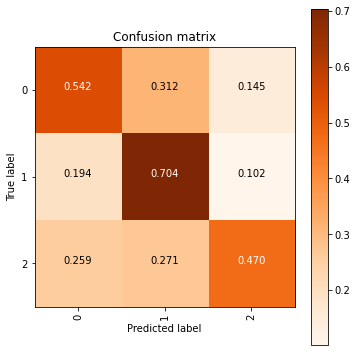

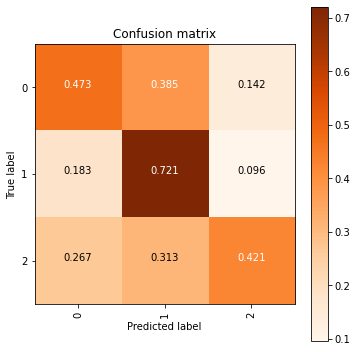

In [ ]:
#Train process
dataloaders = {'train' : train_dataloader, 'val' : dev_dataloader, 'test' : test_dataloader}

print("Training start:..")
epochs = 20

val_acc = 0
optimizer = torch.optim.Adam(Multi_model.parameters(), lr=0.005)
loss = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.9)
for epoch in range(epochs):
    
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_packs, val_packs, model = train_loop(device = device, model = Multi_model,  
                                               model_loss = loss, epochs = epochs, dataloaders = dataloaders, optimizer = optimizer)
    scheduler.step()
    train_loss = train_packs['train_avg_loss']
    train_pred = train_packs['train_total_preds']
    train_accuracy = train_packs['train_epoch_acc']  
    train_f1_score = train_packs['train_f1_metric']  

    val_loss = val_packs['val_avg_loss']
    val_pred = val_packs['val_total_preds']
    val_accuracy = val_packs['val_epoch_acc']  
    val_f1_score = val_packs['val_f1_metric']
    if val_accuracy > val_acc:
        val_acc = val_accuracy
        torch.save(model, '/content/drive/MyDrive/DL_Phase2_models/MixModel.pt')


    print("#######################################################")
    print(f'\nTraining Loss: {train_loss:.3f}, \nTraining Accuracy: {100*train_accuracy:.3f}, \nTraining f1: {100*train_f1_score:.3f}')
    print(f'\ndev Loss: {val_loss:.3f}, \ndev Accuracy: {100*val_accuracy:.3f} \ndev f1: {100*val_f1_score:.3f}')    

classes = [0,1,2]
# Train confusion for bert model
confusion_matrix(classes = classes, y_pred = train_pred, dataloader = dataloaders['train'], dataset_type='train')
# Dev confusion for bert model
confusion_matrix(classes = classes, y_pred = val_pred, dataloader = dataloaders['val'], dataset_type='dev')


test Loss: 0.932, 
test Accuracy: 56.720 
test f1: 56.673
classes [0, 1, 2]
Confusion matrix of test dataset is : 
  [[0.535 0.317 0.147]
 [0.215 0.677 0.107]
 [0.283 0.273 0.445]]


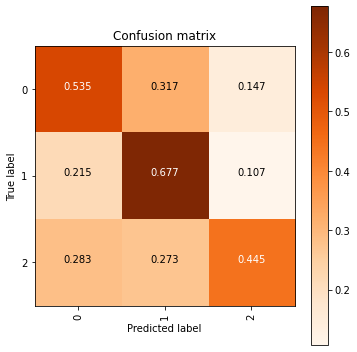

In [ ]:
# Test result for bert model
model = torch.load('/content/drive/MyDrive/DL_Phase2_models/MixModel.pt')
test_loss, test_pred, test_acc, test_f1_metric,  model = test_loop(device, model, loss, dataloaders['test'])
print(f'\ntest Loss: {test_loss:.3f}, \ntest Accuracy: {100*test_acc:.3f} \ntest f1: {100*test_f1_metric:.3f}')    
confusion_matrix(classes = classes, y_pred = test_pred, dataloader = dataloaders['test'], dataset_type='test')